<a id='step9'></a>

# <center>  Dog's Breed Recognition:</center>
<center>**Deep Learning:** Convolutional Neural Networks</center> 

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

### <center>The Road Ahead:</center>


#### <center>[**0. Introduction**](#step0)</center>
#### <center>[**I. Importing Datasets**](#step1)</center>
#### <center>[**II. Humans Detection**](#step2)</center>
#### <center>[**III. Dogs Detection**](#step3)</center>
#### <center>[**IV. Creating a CNN to Classify Dog Breeds(from Scratch)**](#step4) </center> 
#### <center>[**V. Using a CNN to Classify Dog Breeds (using Transfer Learning)**](#step5)</center>
#### <center>[**VI. Creating a CNN to Classify Dog Breeds (using Transfer Learning)**](#step6)</center>
#### <center>[**VII. Writing the Algorithm**](#step7)</center>
#### <center>[**VIII. Testing the Algorithm**](#step8)</center>

<a id='step0'></a>

----------
# <font color='brown'>0. Introduction:</font>

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists. The imperfect solution will nonetheless create a fun user experience!



<a id='step1'></a>

--------------------------------------------------------------
# <font color='brown'>I. Importing Datasets:</font>


### 1-1. Importing the Dog Dataset

In the code cell below, we will import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# Defining a function that loads train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Loading Train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# loading dog names list
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# Print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.
C:\Users\deep-learning\Anaconda3\envs\dog-project\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 1-2. Importing the Human Dataset:

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# Loading filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# Print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


<a id='step2'></a>

-----------------------------

# <font color='brown'>II. Humans Detection:</font>


We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we will use this detector to find human faces in a sample image.

Number of faces detected: 1


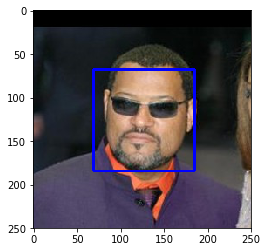

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# Extracting a pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# Loading colors (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Finding faces in image
faces = face_cascade.detectMultiScale(gray)

# Printing number of faces detected in the image
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is a standard procedure to convert images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

###  2-1. Writing Human Face Detector:

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# It returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### 2-2.  Assessing the Human Face Detector:

Using the code cell below we will test the performance of the `face_detector` function.  

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Testing the performance of face_detector on images from human_files_short and dog_files_short.
h_faces=0
d_faces=0

for e in human_files_short:
    if face_detector(e):
        h_faces+=1

for e in dog_files_short:
    if face_detector(e):
        d_faces+=1

print(h_faces*100/float(len(human_files_short)),"% of human faces were detected")
print(d_faces*100/float(len(dog_files_short)),"% of dog images were detected as human faces")

99.0 % of human faces were detected
11.0 % of dog images were detected as human faces


---
<a id='step3'></a>
# <font color='brown'>III. Dogs Detection: </font>

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# Defining ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### 3-1. Data Preprocessing:

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in this dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # Loading RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # Converting PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # Converting 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### 3-2. Making Predictions with ResNet-50:

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  

* The code for `preprocess_input` [here (https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # Returning prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### 3-3. Writing a Dog Detector:

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we  noticed that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to write the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### 3-3. Assess the Dog Detector:

In [11]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
humans=0
dogs=0
for i in range(100):
    if  dog_detector(human_files_short[i]):
        humans+=1
    if  dog_detector(dog_files_short[i]):
        dogs+=1
print(humans*100/float(len(human_files_short)),'% of humans images were detected as a dogs images')
print(dogs*100/float(len(dog_files_short)),'% of dogs images were detected as dogs images')

1.0 % of humans images were detected as a dogs images
100.0 % of dogs images were detected as dogs images


<a id='step4'></a>

----
# <font color='brown'>IV. Creating a CNN to Classify Dog Breeds(from Scratch):</font>


Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### 4-1. Data Preprocessing:

We rescale the images by dividing every pixel in every image by 255.

In [16]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|█████████████████████████████████████| 836/836 [00:37<00:00, 33.50it/s]


### 4-2.  Initial CNN Architecture:


* The first layer is a Convolutional Layer and it is considered also as an input layer. It takes the image array as an input and apply the 16 filters(2x2) strides equal to (1x1) by default. Each filter is related to a node. Since the objects we want to detect aren't too small there is no reason to use the value 'same' in *padding*. I decided to use the "relu" as an activation function to avoid the vanishing gradient problem. Finally the input shape is 224 rows X 224 columns with 3 layer (B,G,R).

* Max Pooling Layer: This type of layers is usually used conv networks between two convolutional layers. It aims to reduce the number of parameters (Reduce the dimensionality of the previous output) in this case the size of the filter is 2x2 and the stride is 2 it returns the maximum value of these 4 pixels at each step.

* Conv 2D: the second convolutional layer apply 32 filters (32 hidden nodes) to detect more complex patterns from the previous output the strides by default is (1X1) padding is equal to valid for the same reason mentioned above. 

* Max Pooling layer same role as mentioned above.

* Conv 2D: Same information mentioned above except the increase of the number of filters to detect more complex patterns.

* Max pooling 2D play the same role.

* Global average pooling 2D: The global average pooling layer reduce extremely the dimensionality of the outputs. The previous output from the max pooling layer above contains 64 arrays each array has a shape of 27x27. The global average pooling layer calculate the average of each array. So, the output will be a vector with 64 field.  

* Dense layer:  The dense layer or the fully connected layer with 133 node each node is responsible for a breed type. Since we have a classification problem I used the softmax function as an activation function.


* Since we want just more than 1% of accuracy I think this architecture is deep enough to attain the objective. The results could be improved by adding two other convolutional layers before the global average layer the first one is a convolutional layer with 128 filters and the second one with 256 filters without forgetting to add the Max Pooling layers after each one of them. By using the global average layer, we will end up by vector with 256 entry which is big enough to use a dense layer with 133 nodes.

In [13]:
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential

model = Sequential()
### Define the architecture.

# Input+ the first convolutional layer
model.add(Conv2D(filters=16, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu', 
                 input_shape=( 224, 224, 3)))

# the first max pooling layer
model.add(MaxPooling2D(pool_size=2))

# The second convolutional layer
model.add(Conv2D(filters=32, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu'))

# The second max pooling layer
model.add(MaxPooling2D(pool_size=2))

# The final convolutional layer
model.add(Conv2D(filters=64, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu'))
# The final maxpooling layer
model.add(MaxPooling2D(pool_size=2))

# The globale average pooling layer
model.add(GlobalAveragePooling2D())

# The output layer
model.add(Dense(133, activation='softmax'))

# return the architecture summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compiling the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

###  Training the Model

In [19]:
from keras.callbacks import ModelCheckpoint  

# the number of epochs 
epochs = 5

### saving the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
### Training the model
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 266s - loss: 4.8831 - acc: 0.0082 - val_loss: 4.8683 - val_acc: 0.0108
Epoch 2/5
6680/6680 [==============================] - 158s - loss: 4.8582 - acc: 0.0121 - val_loss: 4.8398 - val_acc: 0.0180
Epoch 3/5
6680/6680 [==============================] - 158s - loss: 4.8094 - acc: 0.0178 - val_loss: 4.7984 - val_acc: 0.0240
Epoch 4/5
6680/6680 [==============================] - 158s - loss: 4.7604 - acc: 0.0186 - val_loss: 4.7744 - val_acc: 0.0216
Epoch 5/5
6680/6680 [==============================] - 158s - loss: 4.7250 - acc: 0.0243 - val_loss: 4.7525 - val_acc: 0.0204


### Loading the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Testing the Model

In [16]:
# getting the index of predicted dog breeds for each image 
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.3923%


### 4-3. The Alternative Architecture:

In [17]:
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential

model1 = Sequential()
### Defining the architecture.

model1.add(Conv2D(filters=16, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu', 
                 input_shape=( 224, 224, 3)))

model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=32, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu'))

model1.add(MaxPooling2D(pool_size=2))

model1.add(Conv2D(filters=64, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu'))

model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=128, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu'))

model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=256, 
                 kernel_size=2, 
                 padding='valid', 
                 activation='relu'))

model1.add(MaxPooling2D(pool_size=2))

model1.add(GlobalAveragePooling2D())

model1.add(Dense(133, activation='softmax'))


model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 128)       32896     
__________

In [18]:
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from keras.callbacks import ModelCheckpoint  

### the number of epochs 

epochs = 5

### saving the model

checkpointer1 = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_alternative.hdf5', 
                               verbose=1, save_best_only=True)

model1.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer1], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 178s - loss: 4.8658 - acc: 0.0112 - val_loss: 4.7955 - val_acc: 0.0192
Epoch 2/5
6680/6680 [==============================] - 174s - loss: 4.7360 - acc: 0.0193 - val_loss: 4.6661 - val_acc: 0.0347
Epoch 3/5
6680/6680 [==============================] - 175s - loss: 4.6134 - acc: 0.0334 - val_loss: 4.5803 - val_acc: 0.0395
Epoch 4/5
6680/6680 [==============================] - 175s - loss: 4.4778 - acc: 0.0448 - val_loss: 4.4685 - val_acc: 0.0503
Epoch 5/5
6680/6680 [==============================] - 176s - loss: 4.3333 - acc: 0.0552 - val_loss: 4.3555 - val_acc: 0.0587


In [19]:
model1.load_weights('saved_models/weights.best.from_scratch_alternative.hdf5')

In [20]:
# Getting the index of predicted dog breed for each image in test set:
dog_breed_predictions1 = [np.argmax(model1.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy:
test_accuracy1 = 100*np.sum(np.array(dog_breed_predictions1)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions1)
print('Test accuracy for the alternative model: %.4f%%' % test_accuracy1)

Test accuracy for the alternative model: 7.4163%


<a id='step5'></a>

-----
# <font color='brown'>V. Using a CNN to Classify Dog Breeds (using Transfer Learning):</font>

To reduce the training time without sacrificing accuracy, we train the CNN using transfer learning.  
### 5-1. Obtain Bottleneck Features:

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### 5-2. Model Architecture:

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [23]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [30]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 6s - loss: 12.2826 - acc: 0.1207 - val_loss: 11.0610 - val_acc: 0.1784
Epoch 2/20
6680/6680 [==============================] - 4s - loss: 10.2545 - acc: 0.2672 - val_loss: 10.0982 - val_acc: 0.2623
Epoch 3/20
6680/6680 [==============================] - 4s - loss: 9.6328 - acc: 0.3298 - val_loss: 9.9630 - val_acc: 0.2922
Epoch 4/20
6680/6680 [==============================] - 4s - loss: 9.3910 - acc: 0.3635 - val_loss: 9.7578 - val_acc: 0.3174
Epoch 5/20
6680/6680 [==============================] - 4s - loss: 9.2270 - acc: 0.3877 - val_loss: 9.6109 - val_acc: 0.3234
Epoch 6/20
6680/6680 [==============================] - 4s - loss: 9.0804 - acc: 0.4019 - val_loss: 9.5277 - val_acc: 0.3329
Epoch 7/20
6680/6680 [==============================] - 4s - loss: 8.9351 - acc: 0.4199 - val_loss: 9.4937 - val_acc: 0.3353
Epoch 8/20
6680/6680 [==============================] - 4s - loss: 8.8340 

### Load the Model with the Best Validation Loss

In [24]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [25]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.6699%


### Predict Dog Breed with the Model

In [26]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

<a id='step6'></a>

-----
# <font color='brown'>VI. Creating a CNN to Classify Dog Breeds (using Transfer Learning):</font>


We will now use transfer learning to create a CNN that can identify dog breed from images.  

In the previous section, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we will use the bottleneck features from a different pre-trained model.  

To make things easier we will use pre-computed features from ResNet-50 which available in Keras:

- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features


The file is encoded as such:

    DogResnet50Data.npz
    
we will download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.



### 6-1. Bottleneck Features:

In the code block below, we will extract the bottleneck features corresponding to the train, test, and validation sets. 

In [27]:
### Obtain bottleneck features from Resnet50 pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

###  6-2. Model Architecture:

* Since we are using transfer learning with Resnet50, we have a large dataset, the new data is similar to the original training set and the original training set and the new data set share higher level features we could use the entire neural network. 

* As a result, we should add a new fully connected layer (dense layer) with a number of nodes equal to the number of classes in the new data set.

* The first global average pooling2D layer it works as an input layer it flats the 3D input into a vector with 2048 entry.

* The second layer is a fully connected layer with 133 nodes and it uses softmax as activation function to classify each vector in one of The 133 classes (133 dog classifications). Having an input vector with 2048 entry is long enough to use directly a dense layer with 133 nodes.

In [28]:
print(train_Resnet50.shape[0:])

(6680, 1, 1, 2048)


In [29]:
### Defining the architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Compiling the Model

In [30]:
###  Compiling the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [101]:
### Training the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 8s - loss: 1.6115 - acc: 0.5961 - val_loss: 0.8254 - val_acc: 0.7401
Epoch 2/30
6680/6680 [==============================] - 4s - loss: 0.4350 - acc: 0.8639 - val_loss: 0.7503 - val_acc: 0.7749
Epoch 3/30
6680/6680 [==============================] - 4s - loss: 0.2498 - acc: 0.9231 - val_loss: 0.6815 - val_acc: 0.7844
Epoch 4/30
6680/6680 [==============================] - 4s - loss: 0.1697 - acc: 0.9460 - val_loss: 0.6383 - val_acc: 0.8108
Epoch 5/30
6680/6680 [==============================] - 4s - loss: 0.1189 - acc: 0.9630 - val_loss: 0.6597 - val_acc: 0.8036
Epoch 6/30
6680/6680 [==============================] - 5s - loss: 0.0853 - acc: 0.9751 - val_loss: 0.7157 - val_acc: 0.8000
Epoch 7/30
6680/6680 [==============================] - 4s - loss: 0.0636 - acc: 0.9814 - val_loss: 0.6805 - val_acc: 0.8240
Epoch 8/30
6680/6680 [==============================] - 4s - loss: 0.0488 - ac

###  Loading the Model with the Best Validation Loss

In [31]:
### Loading the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Testing the Model

In [32]:
### Calculating classification accuracy on the test dataset.

Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.1435%


### Predicting Dog Breed with the Model:

In the code cell bellow we will Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function from the previous section, this function should have three steps:
1. We will extract the bottleneck features corresponding to the chosen CNN model.
2. We will supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. We will use the `dog_names` array defined in the first section of this notebook to return the corresponding breed.

In [33]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    
    # loading the dog image to the pre-trained model
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # predicting the dog breed
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    
    return dog_names[np.argmax(predicted_vector)]

# testing the function
img_path="images/Labrador_retriever_06449.jpg"
print("Prediction using ResNet50: %r" % (Resnet50_predict_breed(img_path)))

Prediction using ResNet50: 'Labrador_retriever'


---
<a id='step7'></a>

# <font color='brown'>VII. Writing the final Algorithm: </font>

In the code cell bellow we will Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,

- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [34]:
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline
                               
def dog_classifier(img_path):

    # loading color (BGR) image
    img = cv2.imread(img_path)

    # converting BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # converting BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # displaying the image, along with bounding box
    plt.imshow(cv_rgb)

    if face_detector(img_path):# if a human face was detected
        
        # predicting the dog breed related to this human face
        predicted_breed = Resnet50_predict_breed(img_path)
        
        # plotting
        print("Hello, Human!")
        plt.show()
        print("You look like a...")
        
        print(predicted_breed)
    
    elif dog_detector(img_path): # if a dog was detected
        
        # predicting the dog breed
        predicted_breed = Resnet50_predict_breed(img_path)
        
        # plotting
        print(" A Dog is detected in the image. The predicted breed is %s" %predicted_breed)
        plt.show()
    
    else: # 
        
        plt.show()
        print("Unknown Species")

---
<a id='step8'></a>

# <font color='brown'>VIII. Testing the final Algorithm: </font>
In this section, we will take the final algorithm for a spin!  


In [35]:
## testing the algorithm on 14 images
Bulldog="test images/Bulldog.jpg"
Bulldogdown="test images/Bulldog down.jpg"
Bulldogright="test images/Bulldog right.jpg"
Bulldogleft="test images/Bulldog left.jpg"
aryastark="test images/arya stark.jpg"
Bullmastiff="test images/Bullmastiff.jpg"
im4="test images/im4.jpg"
im5="test images/im5.jpg"
CR7="test images/CR7.jpg"
CRdown="test images/CR down.jpg"
CRright="test images/CR right.jpg"
CRleft="test images/CR left.jpg"
sophia1="test images/sophia robot.jpg"
sophia2="test images/sophia.jpg"

 A Dog is detected in the image. The predicted breed is Bulldog


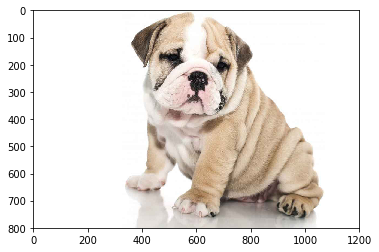

In [36]:
dog_classifier(Bulldog)

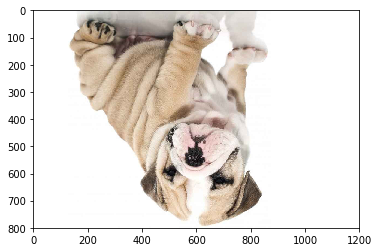

Unknown Species


In [37]:
dog_classifier(Bulldogdown)

 A Dog is detected in the image. The predicted breed is Alaskan_malamute


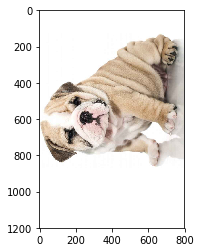

In [38]:
dog_classifier(Bulldogleft)

 A Dog is detected in the image. The predicted breed is Greyhound


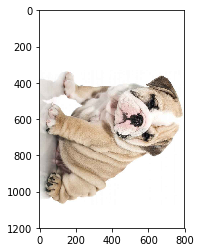

In [39]:
dog_classifier(Bulldogright)

Hello, Human!


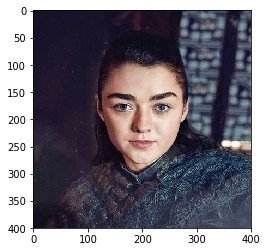

You look like a...
Silky_terrier


In [40]:
dog_classifier(aryastark)

 A Dog is detected in the image. The predicted breed is Bullmastiff


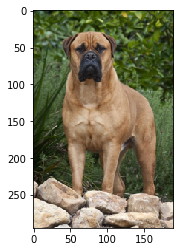

In [41]:
dog_classifier(Bullmastiff)

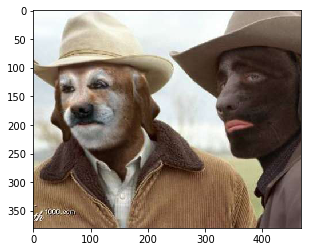

Unknown Species


In [42]:
dog_classifier(im4)

 A Dog is detected in the image. The predicted breed is Dachshund


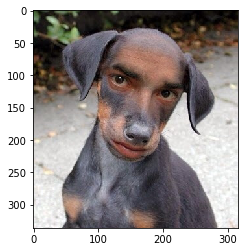

In [43]:
dog_classifier(im5)

Hello, Human!


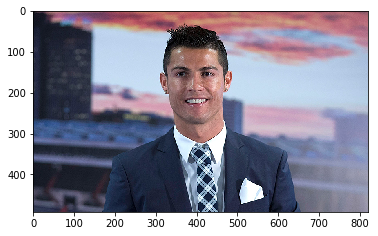

You look like a...
Silky_terrier


In [44]:
dog_classifier(CR7)

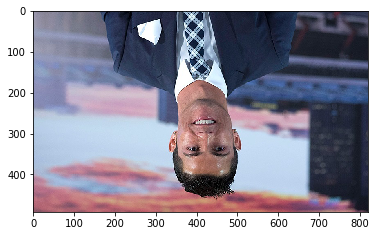

Unknown Species


In [45]:
dog_classifier(CRdown)

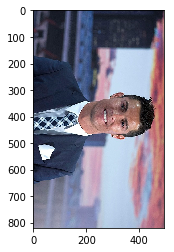

Unknown Species


In [46]:
dog_classifier(CRright)

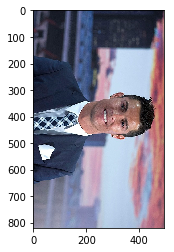

Unknown Species


In [47]:
dog_classifier(CRleft)

Hello, Human!


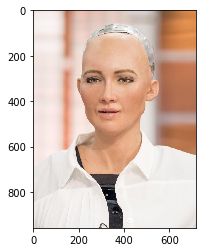

You look like a...
Maltese


In [48]:
dog_classifier(sophia1)

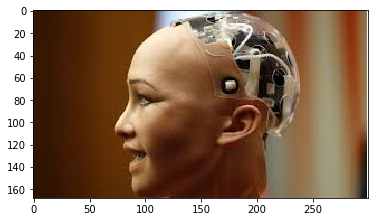

Unknown Species


In [49]:
dog_classifier(sophia2)

# Observations and Improvements:

The results were worse than i expected especially when it comes to human faces. Except for the picture number 5 "the dog with human eyes" the dog detector fails to disclassify it as a dog.

To improve the face detector we need to :

* Improve the human detector:
    - Using Data augmentation to improve the face detector (improve rotation invariance will help to detect all human faces in an image more accurately. CR images)

* Improve the dog detector
    - Using different models to check the dog face details(eyes, mouth, nose...) like if the face contains some weird eyes(check the image "im5").
    - Using image augmentation, and train the model used as a dog detector in a more database to improve the invariance rotation

* Improve the accuracy of the breed predictor model:
    - Using different pre-trained models like : Inception or Xception with very large database contain human faces.

[**Go back to the beginning**](#step9)

###### This project was completed as a part of the **Machine Learning Engineer Nanodegree** from Udacity.